In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Average, Conv2D, Dense, Flatten, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.metrics import AUC
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
meta = pd.read_csv('../processed_data/train.csv', index_col=0)
meta.head()

,target,IP_0001230,IP_0019713,IP_0036322,IP_0038436,IP_0038545,IP_0039318,IP_0041255,IP_0045462,IP_0046310,...,IP_9997715,Unknown,female,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Metadata

In [3]:
y = meta['target'].values.reshape(-1,1)
X = meta.drop('target', axis=1)
meta_train, meta_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=867_5309)

In [4]:
meta_train = meta_train.astype('ushort')
meta_test = meta_test.astype('ushort')

In [5]:
meta_train.shape

(23188, 2065)

In [6]:
y_train.shape

(23188, 1)

### Image data

In [7]:
PATH = '../processed_data/train_img_array.pkl'
with open(PATH, 'rb') as file:
    img_array = pickle.load(file)
img_array = img_array.astype('ushort')
img_train, img_test, _1, _2 = train_test_split(img_array, y, test_size=0.3, random_state=867_5309) # Should split exactly the same as above

In [8]:
img_train.shape

(23188, 80, 120, 3)

In [9]:
img_test.shape

(9938, 80, 120, 3)

### Model

This model with utilize the functional Keras API to produce a mixed model.

In [13]:
# Define inputs
meta_inputs = Input(shape=(2065,))
img_inputs = Input(shape=(80,120,3,))

# Model 1
meta_layer1 = Dense(64, activation='relu')(meta_inputs)
meta_output_layer = Dense(1, activation='sigmoid')(meta_layer1)

# Model 2
padding_layer = ZeroPadding2D(padding=(1,1))(img_inputs)
img_conv_layer1 = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(padding_layer)
img_pooling_layer1 = MaxPooling2D(padding='same')(img_conv_layer1)
img_conv_layer2 = Conv2D(64, kernel_size=(5,5), padding='same', activation='relu')(img_pooling_layer1)
img_pooling_layer2 = MaxPooling2D(padding='same')(img_conv_layer2)
img_conv_layer3 = Conv2D(128, kernel_size=(5,5), padding='same', activation='relu')(img_pooling_layer2)
img_pooling_layer3 = MaxPooling2D(padding='same')(img_conv_layer3)
img_flatten_layer = Flatten()(img_pooling_layer3)
img_dense_layer = Dense(1024, activation='relu')(img_flatten_layer)
img_output_layer = Dense(1, activation='sigmoid')(img_dense_layer)

# Merge models
merged = Average()([meta_output_layer, img_output_layer])

# Define functional model
model = Model(inputs=[meta_inputs, img_inputs], outputs=merged)

# Compile model
auc = AUC(name = 'auc')
model.compile('adam', loss='binary_crossentropy', metrics=[auc])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 80, 120, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 82, 122, 3)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 82, 122, 32)  896         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 41, 61, 32)   0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [14]:
epochs = 15
history = model.fit([meta_train, img_train], y_train, epochs=epochs, batch_size=100, validation_data=([meta_test, img_test], y_test))

Epoch 1/15
232/232 [==============================] - 14s 57ms/step - loss: 0.2202 - auc: 0.5245 - val_loss: 0.0842 - val_auc: 0.7057
Epoch 2/15
232/232 [==============================] - 12s 52ms/step - loss: 0.0827 - auc: 0.8428 - val_loss: 0.0820 - val_auc: 0.7395
Epoch 3/15
232/232 [==============================] - 12s 53ms/step - loss: 0.0776 - auc: 0.9073 - val_loss: 0.0804 - val_auc: 0.7447
Epoch 4/15
232/232 [==============================] - 12s 53ms/step - loss: 0.0722 - auc: 0.9395 - val_loss: 0.0788 - val_auc: 0.7452
Epoch 5/15
232/232 [==============================] - 12s 53ms/step - loss: 0.0642 - auc: 0.9545 - val_loss: 0.0804 - val_auc: 0.7440
Epoch 6/15
232/232 [==============================] - 12s 53ms/step - loss: 0.0566 - auc: 0.9550 - val_loss: 0.0838 - val_auc: 0.7332
Epoch 7/15
232/232 [==============================] - 12s 53ms/step - loss: 0.0482 - auc: 0.9695 - val_loss: 0.0875 - val_auc: 0.7120
Epoch 8/15
232/232 [==============================] - 12s 53ms

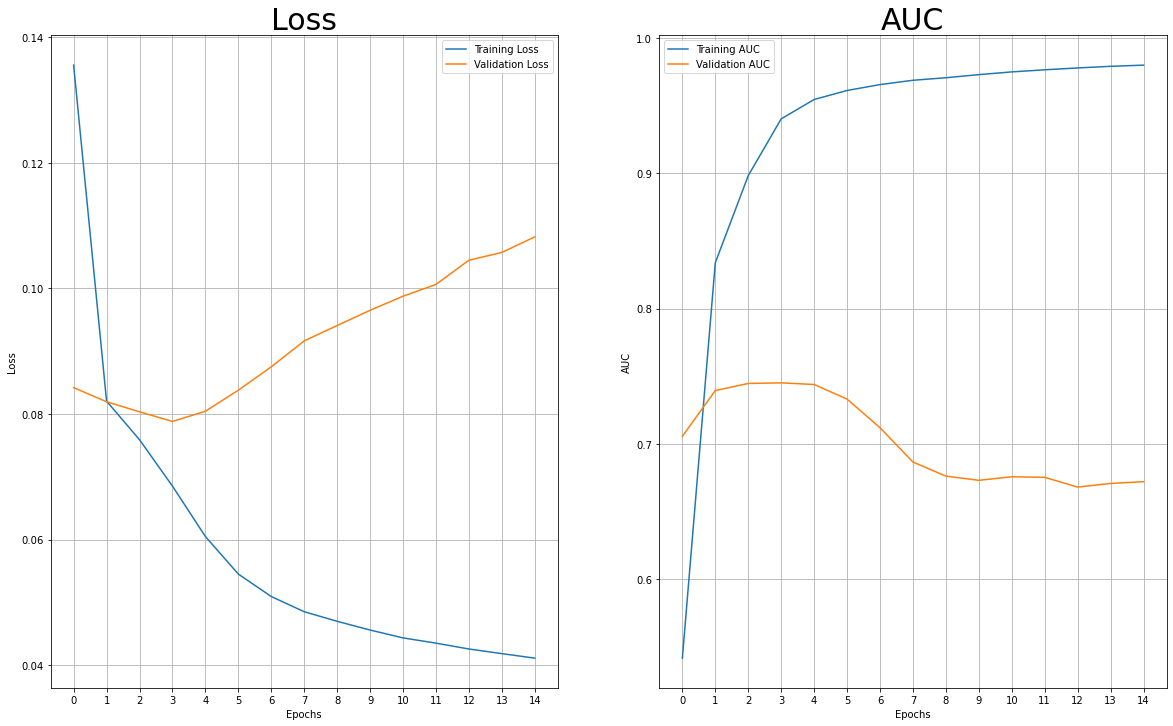

In [15]:
X = np.arange(0, epochs)

plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(X, history.history['loss'], label = 'Training Loss')
plt.plot(X, history.history['val_loss'], label = 'Validation Loss')
plt.grid(True)
plt.xticks(X)
plt.legend()
plt.title('Loss', fontsize=30)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(X, history.history['auc'], label = 'Training AUC')
plt.plot(X, history.history['val_auc'], label = 'Validation AUC')
plt.grid(True)
plt.xticks(X)
plt.legend()
_ = plt.title('AUC', fontsize=30)

There is a great deal of overfitting in this model.